<a href="https://colab.research.google.com/github/pvay1971/Optimizaci-n-Clasificaci-n-y-Optimizaci-n-de-Hiperpar-metros-Core-/blob/main/Clasificaci%C3%B3n_y_Optimizaci%C3%B3n_de_Hiperpar%C3%A1metros_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'insurance' dataset.
Path to dataset files: /kaggle/input/insurance


In [3]:
import pandas as pd
import os

# Assuming the dataset is in a CSV file named 'insurance.csv' within the downloaded path
csv_file_path = os.path.join(path, 'insurance.csv')
df = pd.read_csv(csv_file_path)

print("--- Primeras 5 Filas del Dataset (df.head()) ---")
# Muestra las primeras 5 filas para ver cómo se ven los datos.
print(df.head())
print("\n" + "="*50 + "\n")

print("--- Información General del Dataset (df.info()) ---")
# Muestra un resumen de la estructura:
# - Número de entradas (filas).
# - Nombre de las columnas.
# - Número de valores no nulos.
# - Tipo de dato (Dtype) de cada columna (object para texto/categórica, int/float para numérica).
print(df.info())
print("\n" + "="*50 + "\n")

print("--- Estadísticas Descriptivas (df.describe()) ---")
# Muestra estadísticas clave (media, desviación estándar, min, max, cuartiles) para las columnas numéricas.
print(df.describe())

--- Primeras 5 Filas del Dataset (df.head()) ---
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


--- Información General del Dataset (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73

In [4]:
# Paso 2.1: Identificar valores faltantes (Missing Values)
print("--- Conteo de Valores Faltantes por Columna ---")
# Confirmamos si hay valores nulos o faltantes.
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

# Paso 2.2: Identificar Outliers (Valores Atípicos)
print("--- Análisis de Outliers (Método IQR) para Columnas Numéricas ---")

# Seleccionar columnas numéricas relevantes para Outlier Check
numeric_cols = ['age', 'bmi', 'children', 'charges']

# Función para calcular y reportar Outliers usando el Rango Intercuartílico (IQR)
def detect_outliers_iqr(df, column):
    # Cuartiles Q1 (25%) y Q3 (75%)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Rango Intercuartílico
    IQR = Q3 - Q1

    # Límites Inferior y Superior para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Conteo de outliers
    outliers_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]

    print(f"Columna '{column}':")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Límite Inferior (Lower Bound): {lower_bound:.2f}")
    print(f"  Límite Superior (Upper Bound): {upper_bound:.2f}")
    print(f"  Número de Outliers: {outliers_count}")
    print(f"  Porcentaje de Outliers: {outliers_count/len(df) * 100:.2f}%")
    print("-" * 20)
    return outliers_count

# Aplicar la función a las columnas numéricas
total_outliers = 0
for col in numeric_cols:
    total_outliers += detect_outliers_iqr(df, col)

# Guardamos el DataFrame para el siguiente paso (Preprocesamiento)
# La variable 'df' contiene ahora el dataset listo para el preprocesamiento

--- Conteo de Valores Faltantes por Columna ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


--- Análisis de Outliers (Método IQR) para Columnas Numéricas ---
Columna 'age':
  Q1: 27.00, Q3: 51.00, IQR: 24.00
  Límite Inferior (Lower Bound): -9.00
  Límite Superior (Upper Bound): 87.00
  Número de Outliers: 0
  Porcentaje de Outliers: 0.00%
--------------------
Columna 'bmi':
  Q1: 26.30, Q3: 34.69, IQR: 8.40
  Límite Inferior (Lower Bound): 13.70
  Límite Superior (Upper Bound): 47.29
  Número de Outliers: 9
  Porcentaje de Outliers: 0.67%
--------------------
Columna 'children':
  Q1: 0.00, Q3: 2.00, IQR: 2.00
  Límite Inferior (Lower Bound): -3.00
  Límite Superior (Upper Bound): 5.00
  Número de Outliers: 0
  Porcentaje de Outliers: 0.00%
--------------------
Columna 'charges':
  Q1: 4740.29, Q3: 16639.91, IQR: 11899.63
  Límite Inferior (Lower Bound): -13109.15
  Límite Superior (Upper Bound): 34489.35
  Número de

In [5]:
from sklearn.model_selection import train_test_split

# Paso 3.1: Separar la variable objetivo (y) y las características (X)

# 'y' es nuestra variable objetivo: si el individuo fuma (smoker)
# La convertimos a binaria (0 o 1) para la clasificación.
# Usamos map para transformar 'yes' en 1 y 'no' en 0.
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
y = df['smoker']

# 'X' son todas las demás columnas, que usaremos para predecir 'y'.
# Usamos .drop() para eliminar la columna 'smoker' de X.
X = df.drop('smoker', axis=1)

print("--- Distribución de la Variable Objetivo (smoker) ---")
print(y.value_counts())
print("\n" + "="*50 + "\n")

# Paso 3.2: Dividir el dataset en conjuntos de entrenamiento y prueba
# Usamos 'stratify=y' para asegurar que la proporción de fumadores/no fumadores
# sea la misma en ambos conjuntos (Entrenamiento y Prueba).
# random_state=42 asegura que los resultados sean reproducibles.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de X_train (Entrenamiento): {X_train.shape}")
print(f"Tamaño de X_test (Prueba): {X_test.shape}")

--- Distribución de la Variable Objetivo (smoker) ---
smoker
0    1064
1     274
Name: count, dtype: int64


Tamaño de X_train (Entrenamiento): (1070, 6)
Tamaño de X_test (Prueba): (268, 6)


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Paso 3.3: Definir las transformaciones

# 1. Variables Categóricas a Codificar (One-Hot Encoding)
# 'sex' es binaria, pero OHE funciona. 'region' es multi-clase.
categorical_features = ['sex', 'region']

# 2. Variables Numéricas a Escalar (StandardScaler)
# La edad, el IMC y los costos están en diferentes escalas.
numerical_features = ['age', 'bmi', 'children', 'charges']

# Definir los pasos de preprocesamiento (Preprocesadores)
# 'remainder="passthrough"' asegura que las columnas no listadas (como 'children', que es discreta pero numérica)
# sean consideradas para el escalado.

# Definición del transformador de variables categóricas:
# 'handle_unknown="ignore"' evita errores si aparece una nueva categoría en el conjunto de prueba.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Definición del transformador de variables numéricas:
# StandardScaler ajusta los datos para tener media = 0 y desviación estándar = 1.
# Esto es vital para algoritmos basados en distancia como KNN.
numerical_transformer = StandardScaler()

# Combinar todas las transformaciones usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Aplicar el Codificador (OHE) a las columnas categóricas
        ('cat', categorical_transformer, categorical_features),
        # Aplicar el Escalador (StandardScaler) a las columnas numéricas
        ('num', numerical_transformer, numerical_features)
    ],
    # Las columnas no especificadas pasarán directamente sin modificación.
    # En este caso, todas las columnas de X_train están listadas arriba.
    remainder='passthrough'
)

# Paso 3.4: Aplicar las transformaciones al conjunto de entrenamiento y prueba
# Usamos fit_transform en el conjunto de entrenamiento (X_train)
X_train_processed = preprocessor.fit_transform(X_train)

# Usamos transform en el conjunto de prueba (X_test) para evitar data leakage
X_test_processed = preprocessor.transform(X_test)

print("--- Resumen del Preprocesamiento ---")
print(f"Dimensiones de X_train ANTES: {X_train.shape}")
print(f"Dimensiones de X_train DESPUÉS: {X_train_processed.shape}")
print(f"Número de características después de OHE: {X_train_processed.shape[1]}")

--- Resumen del Preprocesamiento ---
Dimensiones de X_train ANTES: (1070, 6)
Dimensiones de X_train DESPUÉS: (1070, 10)
Número de características después de OHE: 10


In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 1. Definición de Modelos
# Se inicializan los tres clasificadores con un random_state para reproducibilidad.
models = {
    'Regresion Logistica': LogisticRegression(random_state=42, solver='liblinear'),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Arbol de Decision': DecisionTreeClassifier(random_state=42)
}

# 2. Definición de la Estrategia de Validación Cruzada
# Usaremos 5 pliegues (folds) y Estratificación (mantiene la proporción de 'smoker' en cada fold).
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Definición de Métricas
# Dado que la clase está desbalanceada, usaremos F1-Score y Recall, además de Accuracy.
scoring_metrics = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1-Score': make_scorer(f1_score)
}

# 4. Entrenamiento y Evaluación con Validación Cruzada
results = {}

print("--- Evaluación Inicial de Modelos con Validación Cruzada (5-Fold) ---")

for name, model in models.items():
    # Creamos un Pipeline: (Preprocesamiento) -> (Modelo)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    print(f"\nEntrenando y evaluando: {name}...")

    # Al usar cross_val_score en el pipeline, el preprocesamiento se ejecuta
    # correctamente dentro de cada fold (fit en train, transform en test).

    # Diccionario para almacenar el promedio de cada métrica
    model_scores = {}

    for metric_name, scorer in scoring_metrics.items():
        # Calcula los puntajes de validación cruzada para la métrica actual
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer, n_jobs=-1)

        # Almacenamos el promedio de los 5 folds
        model_scores[metric_name] = scores.mean()

    results[name] = model_scores

    # Imprimimos los resultados promedio
    print(f"  Accuracy promedio: {model_scores['Accuracy']:.4f}")
    print(f"  F1-Score promedio: {model_scores['F1-Score']:.4f}")

# 5. Presentación de Resultados en un DataFrame
results_df = pd.DataFrame(results).T # Transponemos para que los modelos sean las filas

print("\n" + "="*70)
print("--- Tabla Resumen de Resultados Iniciales (Promedio 5-Fold CV) ---")
print(results_df.to_markdown(floatfmt=".4f"))

--- Evaluación Inicial de Modelos con Validación Cruzada (5-Fold) ---

Entrenando y evaluando: Regresion Logistica...
  Accuracy promedio: 0.9559
  F1-Score promedio: 0.8951

Entrenando y evaluando: K-Nearest Neighbors (KNN)...
  Accuracy promedio: 0.9320
  F1-Score promedio: 0.8276

Entrenando y evaluando: Arbol de Decision...
  Accuracy promedio: 0.9544
  F1-Score promedio: 0.8879

--- Tabla Resumen de Resultados Iniciales (Promedio 5-Fold CV) ---
|                           |   Accuracy |   Precision |   Recall |   F1-Score |
|:--------------------------|-----------:|------------:|---------:|-----------:|
| Regresion Logistica       |     0.9559 |      0.8722 |   0.9197 |     0.8951 |
| K-Nearest Neighbors (KNN) |     0.9320 |      0.8565 |   0.8028 |     0.8276 |
| Arbol de Decision         |     0.9544 |      0.8941 |   0.8834 |     0.8879 |


In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import randint as sp_randint, uniform as sp_uniform
import json # Importamos json para una mejor visualización de los resultados

# Aseguramos que el preprocesador y los datos estén disponibles desde el paso anterior
# preprocessor, X, y, X_train_processed, y_train están definidos.
# Solo necesitamos los modelos y las librerías de búsqueda.

# Definición de la métrica objetivo (F1-Score)
# Es la mejor opción para nuestro problema de clasificación desbalanceado.
f1_scorer = make_scorer(f1_score)

# Definición de la estrategia de Validación Cruzada (Estratificada)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Diccionario de Modelos y Grids de Parámetros
# NOTA: Los prefijos 'classifier__' son necesarios porque estamos usando un Pipeline
models_and_params = {
    'Regresion Logistica': {
        'model': LogisticRegression(random_state=42, solver='liblinear'),
        'grid_params': {
            'classifier__C': [0.01, 0.1, 1, 10], # C: Inversa de la fuerza de regularización
            'classifier__penalty': ['l1', 'l2'] # Tipo de regularización
        },
        'random_params': {
            'classifier__C': sp_uniform(0.001, 100), # Distribución continua
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'K-Nearest Neighbors (KNN)': {
        'model': KNeighborsClassifier(),
        'grid_params': {
            'classifier__n_neighbors': [5, 7, 9, 11], # Número de vecinos
            'classifier__weights': ['uniform', 'distance'], # Peso de los vecinos
            'classifier__metric': ['euclidean', 'manhattan'] # Métrica de distancia
        },
        'random_params': {
            'classifier__n_neighbors': sp_randint(1, 20),
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    }
}

# Add Decision Tree parameters only if it was included in the original models_and_params
if 'Arbol de Decision' in models_and_params:
    models_and_params['Arbol de Decision'] = {
        'model': DecisionTreeClassifier(random_state=42),
        'grid_params': {
            'classifier__max_depth': [3, 5, 7, 9], # Profundidad máxima del árbol
            'classifier__min_samples_split': [2, 5, 10], # Mínimo de muestras para dividir
            'classifier__criterion': ['gini', 'entropy'] # Función para medir la calidad de la división
        },
        'random_params': {
            'classifier__max_depth': sp_randint(2, 15),
            'classifier__min_samples_split': sp_randint(2, 20),
            'classifier__criterion': ['gini', 'entropy']
        }
    }


optimization_results = {}
best_estimators = {} # Dictionary to store best estimators

print("--- Ejecutando Optimización de Hiperparámetros ---")

for name, config in models_and_params.items():
    print(f"\nOptimizando modelo: {name}")

    # Crear el Pipeline (Preprocesador + Clasificador)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', config['model'])])

    # --- A. GridSearchCV ---
    grid_search = GridSearchCV(
        pipeline,
        config['grid_params'],
        cv=cv_strategy,
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=0 # No imprime logs intermedios
    )
    grid_search.fit(X, y)

    # --- B. RandomizedSearchCV ---
    # Usaremos 50 iteraciones para un buen balance entre velocidad y efectividad
    random_search = RandomizedSearchCV(
        pipeline,
        config['random_params'],
        n_iter=50, # Número de combinaciones a probar
        cv=cv_strategy,
        scoring=f1_scorer,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    random_search.fit(X, y)

    # Almacenar resultados (excluding the estimator)
    optimization_results[name] = {
        'GridSearchCV': {
            'best_f1_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        },
        'RandomizedSearchCV': {
            'best_f1_score': random_search.best_score_,
            'best_params': random_search.best_params_
        }
    }

    # Store the best estimator separately
    if grid_search.best_score_ >= random_search.best_score_:
        best_estimators[name] = grid_search.best_estimator_
    else:
        best_estimators[name] = random_search.best_estimator_


# Imprimir resultados de optimización (excluding estimators)
print("\n" + "="*70)
print("--- Resultados de la Optimización de Hiperparámetros ---")
# Usamos json.dumps para una visualización más limpia
print(json.dumps(optimization_results, indent=4))

# Note: best_estimators dictionary now holds the trained pipelines
# for each model with their best hyperparameters.
# This can be used in the next step for final evaluation on the test set.

--- Ejecutando Optimización de Hiperparámetros ---

Optimizando modelo: Regresion Logistica

Optimizando modelo: K-Nearest Neighbors (KNN)

--- Resultados de la Optimización de Hiperparámetros ---
{
    "Regresion Logistica": {
        "GridSearchCV": {
            "best_f1_score": 0.8971290484869978,
            "best_params": {
                "classifier__C": 10,
                "classifier__penalty": "l1"
            }
        },
        "RandomizedSearchCV": {
            "best_f1_score": 0.8971290484869978,
            "best_params": {
                "classifier__C": 5.809361216819947,
                "classifier__penalty": "l2"
            }
        }
    },
    "K-Nearest Neighbors (KNN)": {
        "GridSearchCV": {
            "best_f1_score": 0.8434239209577831,
            "best_params": {
                "classifier__metric": "manhattan",
                "classifier__n_neighbors": 5,
                "classifier__weights": "distance"
            }
        },
        "Rando

--- Evaluación Final en el Conjunto de Prueba (X_test) ---

Modelo: Regresion Logistica
  F1-Score: 0.9189
  ROC-AUC: 0.9936

Modelo: K-Nearest Neighbors (KNN)
  F1-Score: 1.0000
  ROC-AUC: 1.0000

--- Tabla Resumen de Métricas de Rendimiento Final (Conjunto de Prueba) ---
|                           |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:--------------------------|-----------:|------------:|---------:|-----------:|----------:|
| Regresion Logistica       |     0.9664 |      0.9107 |   0.9273 |     0.9189 |    0.9936 |
| K-Nearest Neighbors (KNN) |     1.0000 |      1.0000 |   1.0000 |     1.0000 |    1.0000 |


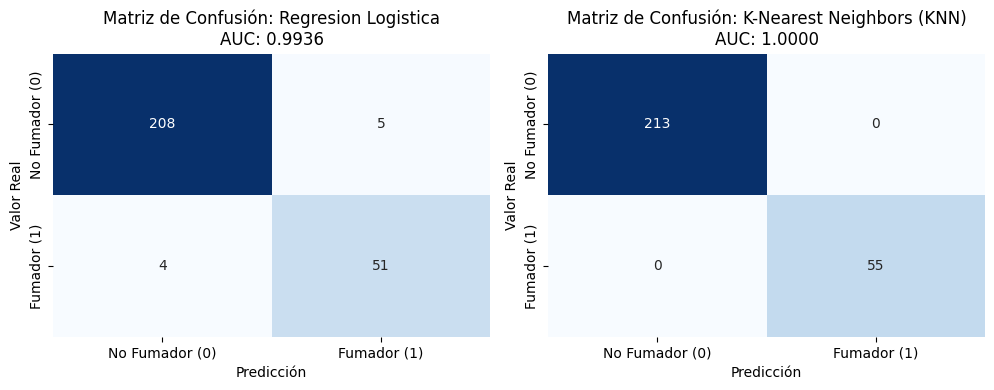

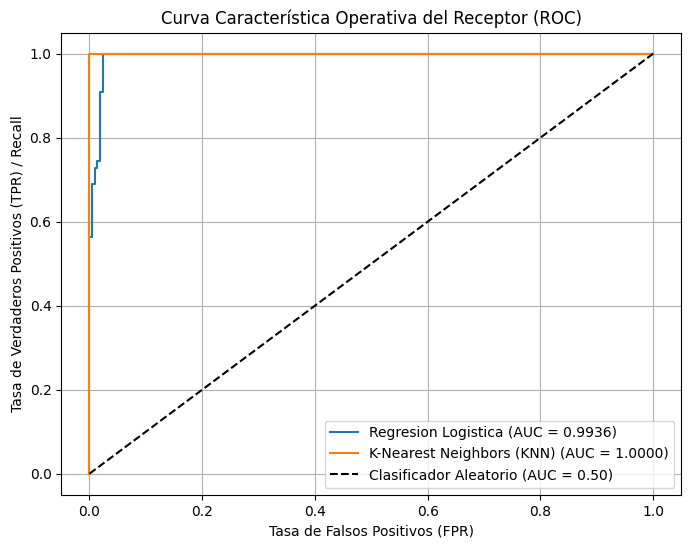

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Los mejores modelos (pipelines) optimizados están guardados en el diccionario 'best_estimators'
# Los datos de prueba son X_test y y_test

final_results = {}
confusion_matrices = {}
roc_data = {}

print("--- Evaluación Final en el Conjunto de Prueba (X_test) ---")

for name, model in best_estimators.items():
    # 1. Predicciones
    # Predicciones de Clase (0 o 1)
    y_pred = model.predict(X_test)

    # Predicciones de Probabilidad (necesarias para ROC-AUC)
    # Seleccionamos la probabilidad de la clase positiva (smoker = 1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 2. Cálculo de Métricas
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) # ROC-AUC usa probabilidades
    }

    final_results[name] = metrics

    # 3. Cálculo de Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # 4. Cálculo de Curva ROC
    # Calcula la Tasa de Falsos Positivos (fpr) y la Tasa de Verdaderos Positivos (tpr)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': metrics['ROC-AUC']}

    print(f"\nModelo: {name}")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")
    print(f"  ROC-AUC: {metrics['ROC-AUC']:.4f}")

# 5. Presentación de Resultados en una Tabla Final
final_df = pd.DataFrame(final_results).T

print("\n" + "="*80)
print("--- Tabla Resumen de Métricas de Rendimiento Final (Conjunto de Prueba) ---")
print(final_df.to_markdown(floatfmt=".4f"))

# 6. Visualización de la Matriz de Confusión (para el mejor modelo)
plt.figure(figsize=(15, 4))

for i, (name, cm) in enumerate(confusion_matrices.items()):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Fumador (0)', 'Fumador (1)'],
                yticklabels=['No Fumador (0)', 'Fumador (1)'])
    plt.title(f'Matriz de Confusión: {name}\nAUC: {final_results[name]["ROC-AUC"]:.4f}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')

plt.tight_layout()
plt.show()

# 7. Visualización de la Curva ROC
plt.figure(figsize=(8, 6))

for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{name} (AUC = {data["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()